In [1]:
%matplotlib inline
import numpy as np
import pandas as pd


import cython
%load_ext Cython

In [2]:
import KF1
import KF2
import KF_Paper
import KF_PaperUni
import KF3
import CKF3
import CKF4
import CKF5
import CKF6
import CKF7
import CKF8
import CKF9
import CKF10
import CKF11

# Kalman filter

Based on Durbin Koopman


For generic state-space systems like (Hamilton's notation):



$$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times p)}{H_t}) $$

$$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t} 
\underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


$$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

Where

* $p$ is the number of observed variables
* $m$ is the number of latent states
* $r$ is the number of disturbances (?)


# Dummy data for the KF with non time-varying parameters

## Local Level model

$$ y_t = \mu_t + \epsilon_t, \qquad \epsilon \sim NID(0, \sigma^2_ \epsilon) $$
$$ \mu_{t+1} = \mu_t + \eta_t, \qquad \eta_t \sim NID(0,\sigma^2_ \eta) $$

# Dummy data

In [3]:
# PARAMETERS
m = 2
p = 4


Z = [[0.3,0.7],[0.1,0],[0.5,0.5],[0,0.3]]


Z = pd.DataFrame(Z)

H = pd.DataFrame(np.diag([1.0,2.0,3.0,4.0]))


T = pd.DataFrame(np.identity(2))
R = pd.DataFrame(np.identity(2))

Q = pd.DataFrame(np.diag([0.2,0.4]))

# GENERATE DATA

n = 10000 #sample size
mut = [np.array([1,10]).reshape(m,1)]
yt = [np.array([0,0,0,0]).reshape(p,1)]

for i in range(0,1000):
    
    temp = np.multiply(np.random.randn(m,1),np.diag(Q).reshape((m,1)))
    temp = R.dot(temp)
    temp = temp + mut[i]
    mut.append(temp)  
    
    temp = np.multiply(np.random.randn(p,1),np.diag(H).reshape((p,1)))
    yt.append(temp+Z.dot(mut[i+1]))

    
yt[0] = pd.DataFrame(yt[0])   
y = pd.concat(yt,axis=1).T.reset_index(drop=True)
mut[0] = pd.DataFrame(mut[0])
mut = pd.concat(mut,axis=1).T.reset_index(drop=True)

# GENERATE PARTIAL NULL

nny = y.copy()
probNan= 0.50
for i in nny.index:
    ran = np.random.uniform(size=nny.iloc[i].shape)
    nny.iloc[i][ran<probNan] = np.nan
    
    
# GENERATE WHOLE NULL

wny = y.copy()
probNan= 0.50
for i in wny.index:
    ran = np.random.uniform(size=(1))
    if ran < probNan:
        wny.iloc[i] = np.nan


In [4]:
nny.head(2)

,0,1,2,3
0,0.0,0.0,NaN,0.000000
1,NaN,NaN,8.6888,0.735229


In [5]:
y = np.array(y)
nny = np.array(nny)
wny = np.array(wny)
Z = np.array(Z)
H = np.array(H)
T = np.array(T)
R = np.array(R)
Q = np.array(Q)

#a1 = (m x 1)
a1 = np.zeros(m)
#P1 = (m x m)
P1 = np.diag(np.ones(m)*1.0)

# Testing the KFs

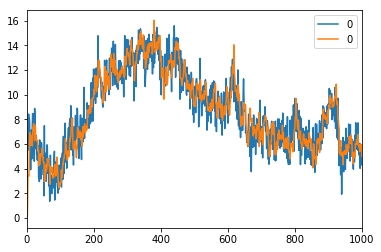

In [6]:
ret = CKF11.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


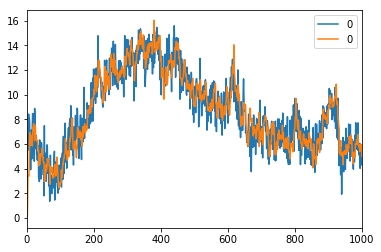

In [7]:
ret = CKF10.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


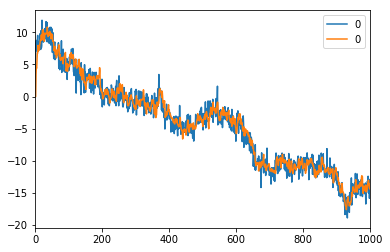

In [8]:
ret = CKF9.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


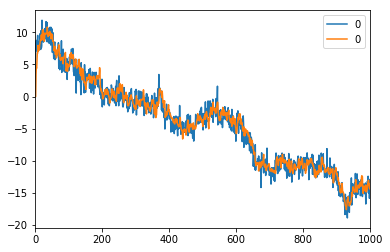

In [9]:
ret = CKF8.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


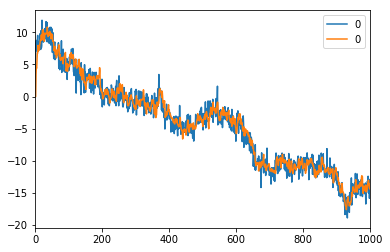

In [10]:
ret = CKF7.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


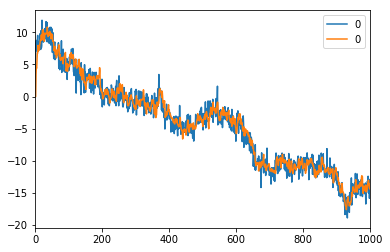

In [11]:
ret = CKF6.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


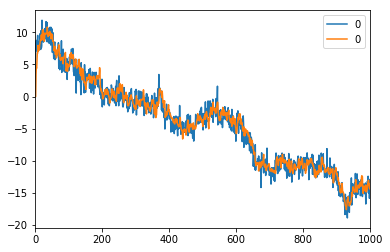

In [12]:
ret = CKF5.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


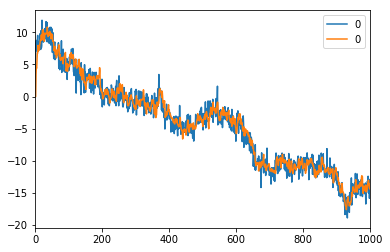

In [13]:
ret = CKF4.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


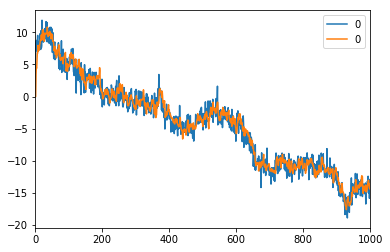

In [14]:
ret = CKF3.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


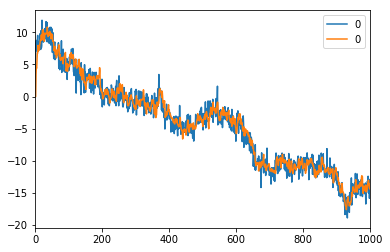

In [15]:
ret = KF3.KalmanFilter(
#     y = y,
#     y = wny,
    y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


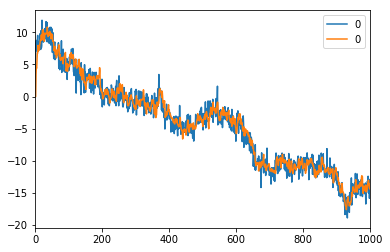

In [16]:
ret = KF2.KalmanFilter(
#     y = y,
#     y = wny,
    y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


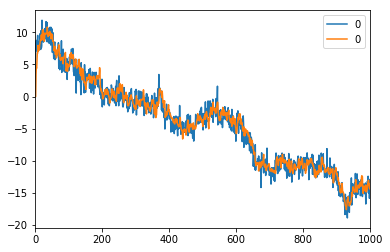

In [17]:
ret = KF1.KalmanFilter(
#     y = y,
#     y = wny,
    y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


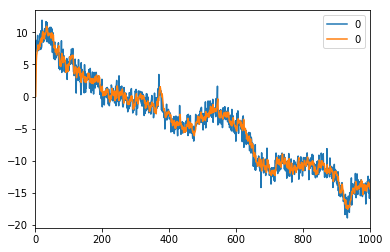

In [18]:
ret = KF_PaperUni.KalmanFilter(
    y = y,
#     y = wny,
#     y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
    nStates = a1.shape[0],
    export=True
)

vy = pd.DataFrame(y)

i = 0

ret = ret['yhat']

pd.concat([vy[i], ret[i]], axis=1).plot()

# Performance

In [19]:
%%timeit

ret = KF_Paper.KalmanFilter(
#     y = y,
#     y = wny,
    y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
    nStates = a1.shape[0]
)

10 loops, best of 3: 141 ms per loop


In [20]:
%%timeit

ret = KF_PaperUni.KalmanFilter(
#     y = y,
#     y = wny,
    y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
    nStates = a1.shape[0],
    export=True
)

10 loops, best of 3: 112 ms per loop


In [21]:
%%timeit

ret = KF1.KalmanFilter(
#     y = y,
#     y = wny,
    y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
)

10 loops, best of 3: 57.7 ms per loop


In [22]:
%%timeit

ret = KF2.KalmanFilter(
#     y = y,
#     y = wny,
    y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
)

10 loops, best of 3: 72 ms per loop


In [23]:
%%timeit

ret = KF3.KalmanFilter(
#     y = y,
#     y = wny,
    y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
)

10 loops, best of 3: 74 ms per loop


In [24]:
%%timeit

ret = CKF3.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

10 loops, best of 3: 68 ms per loop


In [25]:
%%timeit

ret = CKF4.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

10 loops, best of 3: 63.6 ms per loop


In [26]:
%%timeit

ret = CKF5.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

10 loops, best of 3: 53.8 ms per loop


In [27]:
%%timeit

ret = CKF6.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

10 loops, best of 3: 53.8 ms per loop


In [28]:
%%timeit

ret = CKF7.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

10 loops, best of 3: 53.4 ms per loop


In [29]:
%%timeit

ret = CKF8.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

10 loops, best of 3: 55 ms per loop


In [39]:
%%timeit

ret = CKF9.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

10 loops, best of 3: 54.7 ms per loop


In [40]:
%%timeit

ret = CKF10.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

10 loops, best of 3: 49.3 ms per loop


In [41]:
%%timeit

ret = CKF11.KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

10 loops, best of 3: 48.5 ms per loop


## Tests #1 - Dot vs Dgemm

In [21]:
%%cython -a
import numpy as np
cimport numpy as np
import pandas as pd
cimport scipy.linalg.cython_blas as blas
import time

# def f(np.ndarray[np.double_t,ndim=2, mode='fortran'] a, 
#       np.ndarray[np.double_t,ndim=2, mode='fortran'] b,
#       np.ndarray[np.double_t,ndim=2, mode='fortran'] c,
#      ):

cdef f(double[::1,:] a, 
      double[::1,:] b,
       double[::1,:] c,
     ):

    cdef int m, n, k, lda, ldb, ldc
    cdef double alpha, beta

    alpha = 1.0
    beta = 0.0
    lda = 2
    ldb = 2
    ldc = 2
    m = 2
    n = 2
    k = 2

    blas.dgemm('n', #TRANSA
               'n', #TRANSB
               &m, #M
               &n, #N
               &k, #K
               &alpha, #ALPHA
               &a[0,0], #MAtrix A
               &lda, #LDA
               &b[0,0], #MAtrix B
               &ldb, #LDB
               &beta, #BETA
               &c[0,0], #Matrix C
               &ldc) #LDC

#     return c
    return c




#        blas.dgemm('n', #TRANSA
#               'n', #TRANSB
#               <int *> 2, #M
#               <int *> 2, #N
#               <int *> 2, #K
#               <double *> 1, #ALPHA
#               <double *> a_view, #MAtrix A
#               <int *> 2, #LDA
#               <double *> b_view, #MAtrix B
#               <int *> 2, #LDB
#               <double *> 0, #BETA
#               <double *> c_view, #Matrix C
#               <int *> 0) #LDC


cdef multDual(double[::1,:] a, 
      double[::1,:] b,):
    f(a,b,a)
    f(a,b,a)
    return a



def dotMult(np.ndarray[np.double_t,ndim=2, mode='fortran'] a, 
      np.ndarray[np.double_t,ndim=2, mode='fortran'] b,
      ):
    
#     n = 30
#     for i in range(0,1000):
#         for j in range (0,n):
    c = a.dot(b).dot(b)
    return c
            
def fMult(np.ndarray[np.double_t,ndim=2, mode='fortran'] a, 
      np.ndarray[np.double_t,ndim=2, mode='fortran'] b,
      ):
    
#     n = 30
#     for i in range(0,1000):
#         for j in range (0,n):
    f(a,b,a)
    f(a,b,a)
    return a
    
def l(np.ndarray[np.double_t,ndim=2, mode='fortran'] a, 
      np.ndarray[np.double_t,ndim=2, mode='fortran'] b,
      ):

    cdef np.ndarray[np.double_t,ndim=2, mode='fortran'] ac = a.copy(order='F')

#     c = np.empty((2, 2), float, order="F")
    
    timesDot = []
    timesC = []

    n = 30
    
    for i in range(0,10000):
        start_time = time.time()
        for j in range (0,n):
            c = a.dot(b).dot(b)
        end_time = time.time()

        timesDot.append(end_time - start_time)

        ac = a.copy(order='F')
        start_time = time.time()
        for j in range(0,n):
            f(ac,b,ac)
            f(ac,b,ac)
#         time.sleep(1)
        end_time = time.time()
    #     print("--- %s seconds ---" % (end_time - start_time))
        timesC.append(end_time - start_time)

    
#     return np.array(a)
    return {'dot':pd.DataFrame(timesDot), 
            'c' : pd.DataFrame(timesC),
            'final':np.array(ac)
           }



In [22]:
a = np.array(np.random.rand(2,2),float,order='F')
b = np.array(np.random.rand(2,2),float, order='F')
c = np.empty((2,2),float,order='F')

In [23]:
%%timeit

for i in range(0,100):

    a.dot(b).dot(b)

1000 loops, best of 3: 234 µs per loop


In [24]:
%%timeit

for i in range(0,100):

    l(a.copy(order='F'), b.copy(order='F'))

KeyboardInterrupt: 

In [ ]:
# a.dot(b).dot(a).dot(b).dot(b).dot(a).dot(a).dot(b).dot(b).dot(a)
a.dot(b).dot(b)

In [ ]:
ret = l(a.copy(order='F'), b.copy(order='F'))

In [ ]:
ret['final']

In [ ]:
dev = (ret['dot']-ret['c'])

In [ ]:
dev.describe()

# Test #2 - memory view vs ndarray

In [ ]:
%%cython

import numpy as np
cimport numpy as np

def main1(np.ndarray[np.double_t,ndim=2] a,np.ndarray[np.double_t,ndim=2] b):

    cdef np.ndarray[np.double_t,ndim=2] c = np.empty((2,2))

    for i in range(0,1000):
        c = a.dot(b)
    return c

    
def main2(np.ndarray[np.double_t,ndim=2] a,np.ndarray[np.double_t,ndim=2] b):

    cdef double[:,:] c = np.empty((2,2))

    for i in range(0,1000):
        c = a.dot(b)
    return c    
    
# def main2(double[:,:] a,double[:,:] b):

#     cdef double[:,:] c = np.empty((2,2))

#     for i in range(0,100):
#         c = a.dot(b)
#         return c
    

In [ ]:
a = np.array(np.random.rand(2,2),float)
b = np.array(np.random.rand(2,2),float)

In [ ]:
%%timeit 

main1(a,b)

In [ ]:
%%timeit 

main2(a,b)

Next Steps:

separate test 1 in two functions
disable gil, and decorators


# Test #3 - Decorators

In [ ]:
%%cython -a
# %%cython 

import numpy as np
cimport numpy as np
import pandas as pd
cimport scipy.linalg.cython_blas as blas
import time
cimport cython

# def f(np.ndarray[np.double_t,ndim=2, mode='fortran'] a, 
#       np.ndarray[np.double_t,ndim=2, mode='fortran'] b,
#       np.ndarray[np.double_t,ndim=2, mode='fortran'] c,
#      ):


@cython.boundscheck(False)  
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)
cdef void f(double[::1,:] a, 
      double[::1,:] b,
       double[::1,:] c,
     ) nogil:

    cdef int m, n, k, lda, ldb, ldc
    cdef double alpha, beta

    alpha = 1.0
    beta = 0.0
    lda = 2
    ldb = 2
    ldc = 2
    m = 2
    n = 2
    k = 2

    blas.dgemm('n', #TRANSA
               'n', #TRANSB
               &m, #M
               &n, #N
               &k, #K
               &alpha, #ALPHA
               &a[0,0], #MAtrix A
               &lda, #LDA
               &b[0,0], #MAtrix B
               &ldb, #LDB
               &beta, #BETA
               &c[0,0], #Matrix C
               &ldc) #LDC

#     return c
#     return c




#        blas.dgemm('n', #TRANSA
#               'n', #TRANSB
#               <int *> 2, #M
#               <int *> 2, #N
#               <int *> 2, #K
#               <double *> 1, #ALPHA
#               <double *> a_view, #MAtrix A
#               <int *> 2, #LDA
#               <double *> b_view, #MAtrix B
#               <int *> 2, #LDB
#               <double *> 0, #BETA
#               <double *> c_view, #Matrix C
#               <int *> 0) #LDC



@cython.boundscheck(False)  
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.cdivision(True)
@cython.nonecheck(False)
def dotMult(np.ndarray[np.double_t,ndim=2, mode='fortran'] a, 
      np.ndarray[np.double_t,ndim=2, mode='fortran'] b,
      ):
    
#     n = 30
    for i in range(0,10000):
#         for j in range (0,n):
        c = a.dot(b).dot(b)
    return c
         
@cython.boundscheck(False)  
@cython.wraparound(False)
@cython.initializedcheck(False)
def fMult(np.ndarray[np.double_t,ndim=2, mode='fortran'] a, 
      np.ndarray[np.double_t,ndim=2, mode='fortran'] b,
      ):
    
#     n = 30
    for i in range(0,10000):
#         for j in range (0,n):
        f(a,b,a)
        f(a,b,a)
    return a
    
def l(np.ndarray[np.double_t,ndim=2, mode='fortran'] a, 
      np.ndarray[np.double_t,ndim=2, mode='fortran'] b,
      ):

    cdef np.ndarray[np.double_t,ndim=2, mode='fortran'] ac = a.copy(order='F')

#     c = np.empty((2, 2), float, order="F")
    
    timesDot = []
    timesC = []

    n = 30
    
    for i in range(0,100000):
        start_time = time.time()
        for j in range (0,n):
            c = a.dot(b).dot(b)
        end_time = time.time()

        timesDot.append(end_time - start_time)

        ac = a.copy(order='F')
        start_time = time.time()
        for j in range(0,n):
            f(ac,b,ac)
            f(ac,b,ac)
#         time.sleep(1)
        end_time = time.time()
    #     print("--- %s seconds ---" % (end_time - start_time))
        timesC.append(end_time - start_time)

    
#     return np.array(a)
    return {'dot':pd.DataFrame(timesDot), 
            'c' : pd.DataFrame(timesC),
            'final':np.array(ac)
           }




In [ ]:
a = np.array(np.random.rand(2,2),float,order='F')
b = np.array(np.random.rand(2,2),float, order='F')
c = np.empty((2,2),float,order='F')

In [ ]:
a.dot(b).dot(b)

In [ ]:
dotMult(a,b)

In [ ]:
fMult(a,b)

In [ ]:
%%timeit

dotMult(a,b)

In [ ]:
%%timeit

fMult(a,b)

# Line Profiler

In [44]:
%load_ext line_profiler
import line_profiler

from Cython.Compiler.Options import directive_defaults

directive_defaults['linetrace'] = True
directive_defaults['binding'] = True

In [47]:
%%cython -a -f --compile-args=-DCYTHON_TRACE=1

import numpy as np
cimport numpy as np
import pandas as pd
import time
from cpython cimport bool
import line_profiler
cimport cython

from libc.math cimport isnan

ctypedef np.double_t DTYPE_t

##### KF
# Univariate version of durbin and koopman
# Should be the same as CKF10 but changing some indexing



@cython.boundscheck(False)
@cython.wraparound(False)
cdef int getSum(double [:,:] arr,int t, int p) :

    cdef int i
    cdef int s = 0

    for i in range(0,p):
#        print(arr[i])
        if not isnan(arr[t,i]):
             s += 1
    return s

#def KalmanFilter(y, Z, Hsq, T, Q, a1, P1, R):
@cython.boundscheck(False)
@cython.wraparound(False)
#@cython.initializedcheck(False)
#@cython.cdivision(True)
#@cython.nonecheck(False)
#@profile
def KalmanFilter(
        np.ndarray[DTYPE_t, ndim=2] y,
        np.ndarray[DTYPE_t, ndim=2] Z,
        np.ndarray[DTYPE_t, ndim=2] Hsq,
        np.ndarray[DTYPE_t, ndim=2] T,
        np.ndarray[DTYPE_t, ndim=2] Q,
        np.ndarray[DTYPE_t, ndim=1] a1,
        np.ndarray[DTYPE_t, ndim=2] P1,
        np.ndarray[DTYPE_t, ndim=2] R
   ) :

    # p = number of variables in Yt
    # y should be (n x p)

    cdef int n,p,m,t,i,pt

    n = y.shape[0]
    p = y.shape[1]
    m = a1.shape[0] #number of states


    cdef np.ndarray[DTYPE_t,ndim=3] a = np.empty((n+1,p+1,m))
    a[0,0,:] = a1

    cdef np.ndarray[DTYPE_t,ndim=2] P = np.empty((m, m))
    P[:,:] = P1

    cdef np.ndarray[DTYPE_t,ndim=1] K = np.empty((m))

    cdef double v,F


    # RQR = np.linalg.multi_dot([R, Q, R.T])
    cdef np.ndarray[DTYPE_t,ndim=2] RQR = R.dot(Q).dot(R.T)

    cdef np.ndarray[DTYPE_t,ndim=2] TT = T.T

    yhat = np.empty((n,p)) #Later I should use it to export in numpy not pandas

#    cdef np.ndarray[np.uint8_t,ndim=1, cast=True] yind = np.empty(p)
    yind = np.empty(p)

    cdef np.ndarray[DTYPE_t,ndim=1] yt = np.empty(p)
    cdef np.ndarray[DTYPE_t,ndim=2] Zt = np.empty((p, m))
    cdef np.ndarray[DTYPE_t,ndim=1] Ht = np.empty(p)

#    cdef double[:,:] v_mv = v
#    cdef double[:,:] F_mv = F
#    cdef double[:,:,:] K_mv = K
#    cdef double[:,:,:] a_mv = a
#    cdef double[:,:,:,:] P_mv = P

    # times = []
    cdef np.ndarray[DTYPE_t,ndim=1] H = np.diag(Hsq) #ONLY WORKS FOR DIAGONAL H

    cdef double[:,:] y_mv = y

    yindGlobal = ~np.isnan(y)

    for t in range(0, n):
        # decide pt and yt
        yind = yindGlobal[t,:]

#        pt = yind.sum()

#        print(pt)
#        print(yind)
#        print(y[t,:])
        pt = getSum(y_mv, t, p)
        

        yt[:pt] = y[t,yind]
#         yt[:pt] = y[t,yind]
        Zt[:pt,:] = Z[yind,:]
        Ht[:pt] = H[yind] #ONLY WORKS FOR DIAGONAL H

        for i in range(0, pt):

            v = yt[i] - np.dot(Zt[i], a[t,i,:])

            # F[t,i] = np.linalg.multi_dot([Z[i], P[t, i,:,:], Z[i]]) + H[i, i]
            F = Zt[i].dot(P[:,:]).dot(Zt[i]) + Ht[i]

            K[:] = P[:,:].dot(Zt[i]) * (F**(-1))

            a[t,i+1,:] = a[t,i,:] + K[:] * v

#            P[:,:] += - np.outer(K * F, K)
            P[:,:] += - np.dot(K[:,None] * F, K[None,:])


        a[t+1,0,:] =  T.dot(a[t, pt, :])

        # P[t+1, 0,:,:] = np.linalg.multi_dot([T, P[t, i + 1,:,:], TT]) + RQR
        P[:, :] = T.dot(P[:,:]).dot(TT) + RQR


        # times.append(temp1 == temp2)


    alpha = a[:n, 0,:]
    yhat = pd.DataFrame(np.dot(Z, alpha.T).T)

    # pd.DataFrame(times).to_pickle("Mult")
    # pd.DataFrame(times).to_pickle("Dot")
    return yhat



In [48]:
profile = line_profiler.LineProfiler(KalmanFilter)
profile.runcall(KalmanFilter, nny,Z,H,T,Q,a1,P1, R)
profile.print_stats()

Timer unit: 4.10257e-07 s

Total time: 0.0674507 s
File: C:\Users\pedro.mattos\.ipython\cython\_cython_magic_f7d9e565cb4455fd32899d535c4716ac.pyx
Function: KalmanFilter at line 40

Line #      Hits         Time  Per Hit   % Time  Line Contents
    40                                           def KalmanFilter(
    41                                                   np.ndarray[DTYPE_t, ndim=2] y,
    42                                                   np.ndarray[DTYPE_t, ndim=2] Z,
    43                                                   np.ndarray[DTYPE_t, ndim=2] Hsq,
    44                                                   np.ndarray[DTYPE_t, ndim=2] T,
    45                                                   np.ndarray[DTYPE_t, ndim=2] Q,
    46                                                   np.ndarray[DTYPE_t, ndim=1] a1,
    47                                                   np.ndarray[DTYPE_t, ndim=2] P1,
    48                                                   np.ndarray[D

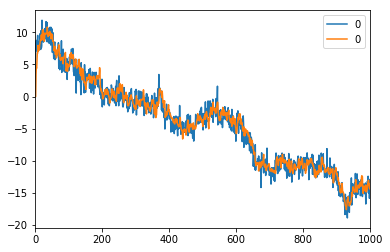

In [49]:
ret = KalmanFilter(nny,Z,H,T,Q,a1,P1, R)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


In [21]:
%%cython 

import numpy as np
cimport numpy as np


# cdef void func(double* letsee):
#     for i in range(0,4):
# #         if not isnan(letsee[i]):
#             print(letsee[i])
#             print(isnan(letsee[i]))

def main1():
#     cdef np.ndarray[np.double_t,ndim=2] a = np.array([[1,np.nan,3,4],[1,np.nan,3,4]])

    n = 10
    cdef np.ndarray[np.double_t,ndim=2] a = np.random.randn(n,n)
    
    cdef np.ndarray[np.double_t,ndim=2] b
    
    cdef double[:,:] a_mv = a
    
    ind = np.ones(n)
    ind[3] = np.nan
    ind[5] = np.nan
    ind[7] = np.nan
    
    
    print(np.array(a_mv))
    print("Hey")
    print(np.array(a_mv[5,(1,3)]))
    
    
#     cdef int[:] intInd = np.array([0,1,2,4,6,8,9])
    
#     for i in range(0,100):
#         b = a[5,ind]
        
    
    
#     return b

# def main2():
# #     cdef np.ndarray[np.double_t,ndim=2] a = np.array([[1,np.nan,3,4],[1,np.nan,3,4]])

#     n = 10
#     cdef np.ndarray[np.double_t,ndim=2] a = np.random.randn(n,n)
    
#     cdef np.ndarray[np.double_t,ndim=2] b
    
#     cdef double[:,:] a_mv = a
    
#     ind = np.ones(n)
#     ind[3] = np.nan
#     ind[5] = np.nan
#     ind[7] = np.nan
    
#     cdef int[:] intInd = np.array([0,1,2,4,6,8,9])
    
#     for i in range(0,100):
#         b = a_mv[5,intInd]
        
    
    
#     return b


Error compiling Cython file:
------------------------------------------------------------
...
    ind[7] = np.nan
    
    
    print(np.array(a_mv))
    print("Hey")
    print(np.array(a_mv[5,(1,3)]))
                          ^
------------------------------------------------------------

C:\Users\pedro.mattos\.ipython\cython\_cython_magic_d4edcb449a25e5b2b2ff755619f47345.pyx:30:27: Invalid index for memoryview specified, type (long, long)


In [22]:
main1()

[[ -1.84431886e+00  -9.49497522e-01  -7.55204358e-01   7.92296013e-01
   -5.15220323e-01   4.92967769e-01  -1.11959677e+00   1.41282936e+00
   -9.76997252e-01  -3.07523775e-03]
 [ -5.72512918e-04   1.28375068e-01  -9.83328445e-01  -5.15255056e-02
   -5.76590036e-01  -3.93038133e-01  -2.97628022e-01  -3.92679588e-01
    1.70319534e+00  -7.98156104e-01]
 [  2.18638200e+00  -1.10903644e+00  -4.81215832e-01   2.01569269e-01
   -2.36572048e-01  -9.97433216e-01   3.96916600e-02   7.03860415e-01
    1.88488261e+00   4.71672265e-01]
 [ -2.49285286e-01  -1.86256254e-01   1.47389354e-01  -3.58631319e-01
    4.25614390e-01  -8.57931459e-01   8.23768918e-01  -5.35666956e-01
    1.87071207e+00  -9.63486884e-02]
 [ -1.43249714e+00   1.75738725e-01  -4.13322319e-01  -2.08350033e-01
    1.49490756e+00   1.75408148e+00   4.51537992e-01  -3.33391870e-02
    5.16260346e-02   2.36054914e-01]
 [ -1.16075661e+00   1.57308621e+00   1.95394366e-01   1.76965992e-01
   -1.18967781e-01   2.54973940e-01   9.39800

In [6]:
a = np.empty(2)
a[:] = np.array([1,2,3])

ValueError: could not broadcast input array from shape (3) into shape (2)

In [26]:
x = np.random.randn(5,5)
x

array([[-0.56313056, -1.27834803, -0.30052179, -2.00063006, -2.05059544],
       [-0.44563071, -0.63580159, -0.67538499, -0.9192516 ,  0.49663121],
       [ 2.11943794, -0.51746142, -0.80092609, -0.89391932,  1.91359607],
       [ 0.52593344, -0.59931707,  0.78093441, -1.62449658, -1.65887717],
       [-0.46422764,  0.96595406, -0.47142008, -0.28886925, -1.86674776]])

In [27]:
x[2,[1,2]]

array([-0.51746142, -0.80092609])

In [10]:
%%cython -a
cimport cython
@cython.cdivision(True)
def main1(double x, int n):
    cdef double res  = 0
    for i in range(0,n):
        res += 1/x
    return res

def main2(double x, int n):
    cdef double res  = 0
    for i in range(0,n):
        res += x ** -1
    return res
        

In [18]:
i=7
n=100000

In [19]:
main1(i,n)

14285.714285698234

In [20]:
main2(i,n)

14285.714285698234

In [24]:
%timeit main1(i,n)
%timeit main2(i,n)

10000 loops, best of 3: 110 µs per loop
10000 loops, best of 3: 108 µs per loop
